**The code was inspired from the official documnetation of TensorFlow**


In [ ]:
#------------------------------------------#
#     Projet Machine Learning Avancé       #
#------------------------------------------#
#               Master 2 ISI               #

#     Membres du Groupe :                  #
#     - Tarek BENAISSA                     #
#     - Mhamed BENABID                     #
#     - Zahra Hafida BENSLIMANE            #
#     - Mohammed El Amine BENBRAHIM         #
#------------------------------------------#

In [ ]:
!pip install tensorflow_text

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# cette variable est utilisée pour basculer entre les implémentations personnalisées ( qu'on crée à partir de zéro) et intégrées.
use_builtins = True

In [ ]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                           f'    found {rank}: {shape.numpy()}\n'
                           f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                             f"    found: {new_dim}\n"
                             f"    expected: {old_dim}\n")
                             


In [ ]:
# format des données en entrée
# input target
# Qui est-il ? Who is it?

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'fra-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'fra.txt'

In [ ]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [ ]:
targ, inp = load_data(path_to_file)
print("entrée : ",inp[-1])


entrée :  Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.


In [ ]:
print("cible : ",targ[-1])

cible :  It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.


In [ ]:
# Taille des données en entrée
print("nombre de phrase contenu dans les données : ", len(inp))
# On entraine sur 167130 phrase avec des longueur variable allant des plus petites au plus longues

# pour montrer qu'on a des longueurs différentes
taille_input = [len(p) for p in inp]
print("nombre de mot de la plus petite phrase : ", min(taille_input))
print("nombre de mot de la plus longue phrase : ", max(taille_input))

nombre de phrase contenu dans les données :  167130
nombre de mot de la plus petite phrase :  4
nombre de mot de la plus longue phrase :  349


In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
print("Si on prend toutes les données on aura",round(BUFFER_SIZE/BATCH_SIZE), "exemples pour chaque epoque")


Si on prend toutes les données on aura 2611 exemples pour chaque epoque


In [ ]:
# on mélange les données pour ne pas avoir que des phrases de même longueur
# pour un entrainement plus léger on peut limiter les données en entrée à (inp[:50000], targ[:50000]) 
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Qui \xc3\xaates-vous tous\xe2\x80\xaf?'
 b"Ce n'est pas ce que tu veux faire." b'Je connais votre genre.'
 b'Il vous a trahi.' b'Mon p\xc3\xa8re ne permettra pas cela.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Who are you all?' b"That's not what you want to do."
 b'I know your type.' b'He betrayed you.' b"My father won't allow that."], shape=(5,), dtype=string)


In [ ]:
# On a des problème ou y'a des accents, il faut travailler en unicode, on normalise en montrant d'abord la lettre
# La normalisation Unicode pour diviser les caractères accentués et remplacer les caractères de compatibilité par leurs équivalents ASCII.
example_text = tf.constant('Tu est toujours à la maison?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Tu est toujours \xc3\xa0 la maison?'
b'Tu est toujours a\xcc\x80 la maison?'


In [ ]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # on ajoute des indicateurs de début et fin de phrase
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [ ]:
print(example_text.numpy().decode())
# on garde que la lettre sans accent
print(tf_lower_and_split_punct(example_text).numpy().decode())

Tu est toujours à la maison?
[START] tu est toujours a la maison ? [END]


In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [ ]:
example_tokens = input_text_processor(example_input_batch)
# quelques phrases tokenisées
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2,  39, 105,  85,   8,   3,   0,   0,   0,   0],
       [  2,  20,  70,   9,  20,  10,  21,  47,  31,   4],
       [  2,   5, 372,  59, 523,   4,   3,   0,   0,   0]])>

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] qui etesvous tous ? [END]             '

Text(0.5, 1.0, 'Mask')

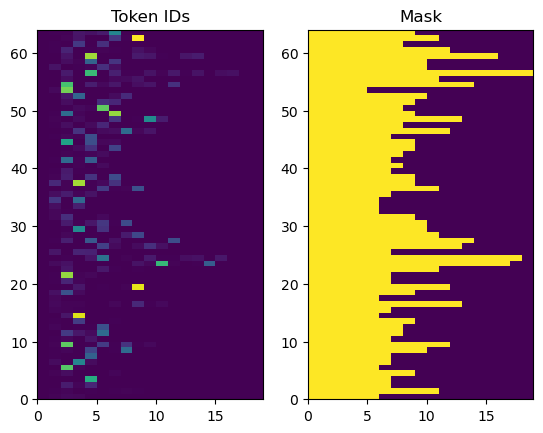

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
embedding_dim = 256
units = 1000 # nombre de neurones des couches de l'encodeur et décodeur

In [ ]:
# Till now, we have used a monodirectional GRU instead of a bidirectional as first tests.
# However, in the next version we will use the bidirectional GRU.
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       # Return the sequence and state
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Returns the new sequence and its state.
        return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 19)
Encoder output, shape (batch, s, units): (64, 19, 1000)
Encoder state, shape (batch, units): (64, 1000)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(units)

In [ ]:
(example_tokens != 0).shape

TensorShape([64, 19])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1000)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 19)


Text(0.5, 1.0, 'Mask')

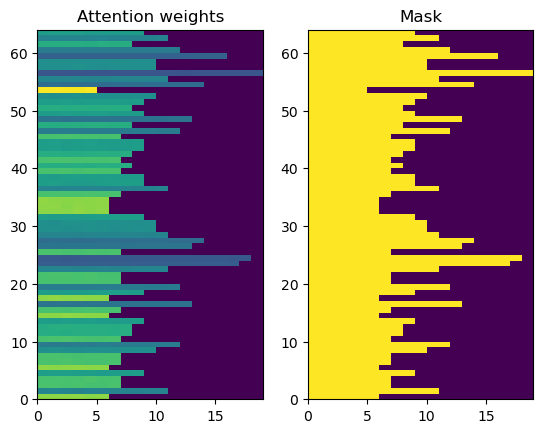

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
attention_weights.shape

TensorShape([64, 2, 19])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1000)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['suspected'],
       ['plan'],
       ['dozed'],
       ['way'],
       ['caused']], dtype='<U16')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                   input_text_processor,
                   output_text_processor, 
                   use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                 enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [ ]:
%%time
for n in range(10):
      print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5706186>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.53916>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4789295>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3034635>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.647581>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1521173>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.648046>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4589624>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2081137>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0415454>}

CPU times: user 1min 56s, sys: 2.41 s, total: 1min 58s
Wall time: 44.5 s


In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
      return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9242303>}

In [ ]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8988004>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9063084>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8385468>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7314546>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7027087>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6707034>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.617001>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5801218>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5387888>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4983494>}

CPU times: user 1min 7s, sys: 2.23 s, total: 1min 9s
Wall time: 17.8 s


....................................................................................................


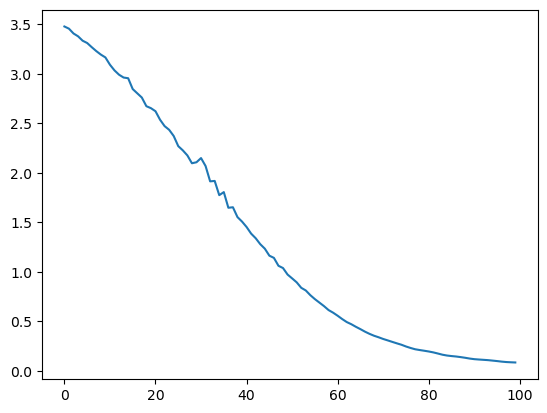

In [ ]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
2612/2612 [==============================] - 4272s 2s/step - batch_loss: 1.7486
Epoch 2/3
2612/2612 [==============================] - 4253s 2s/step - batch_loss: 0.9014
Epoch 3/3
2612/2612 [==============================] - 4269s 2s/step - batch_loss: 0.6916


Text(0, 0.5, 'CE/token')

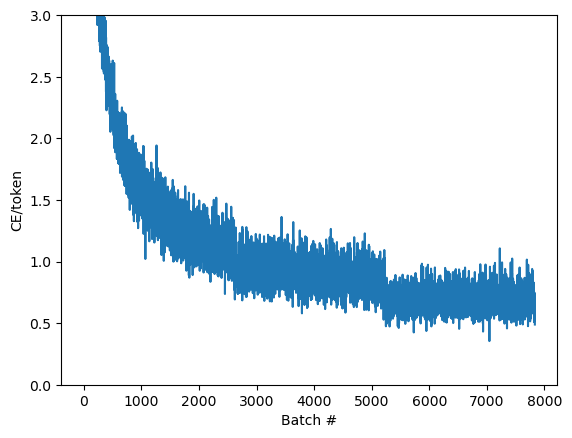

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor,
                   output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/tmp/wsuser/ipykernel_416/2407734992.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


In [ ]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'choose terrible', b'rate resembles', b'due holidays',
       b'row alphabet', b'dropped grades'], dtype=object)

In [ ]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2228],
       [3527],
       [2962],
       [2177],
       [4341]])>

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                 enc_output=enc_output,
                                 mask=(input_tokens!=0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
print(inp[4500])

Nous sommes fortes.


In [ ]:
%%time
input_text = tf.constant([
    'Ça aura lieu demain.', # "It's really cold here."
    'Nous sommes fortes.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

itll be place tomorrow .
were strong .

CPU times: user 274 ms, sys: 12.1 ms, total: 286 ms
Wall time: 188 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
      return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 18.7 s, sys: 113 ms, total: 18.9 s
Wall time: 18.2 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its going to be place tomorrow .
were strong .

CPU times: user 881 ms, sys: 45.4 ms, total: 926 ms
Wall time: 317 ms


In [ ]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

itll be here tomorrow .
were strong .

CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 201 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 2.01 s, sys: 7.79 ms, total: 2.01 s
Wall time: 1.88 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

will be convenient tomorrow on .
were strong .

CPU times: user 167 ms, sys: 12.3 ms, total: 179 ms
Wall time: 56.8 ms


In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[0.99999994 1.         1.         1.         1.         1.0000001
 1.        ]


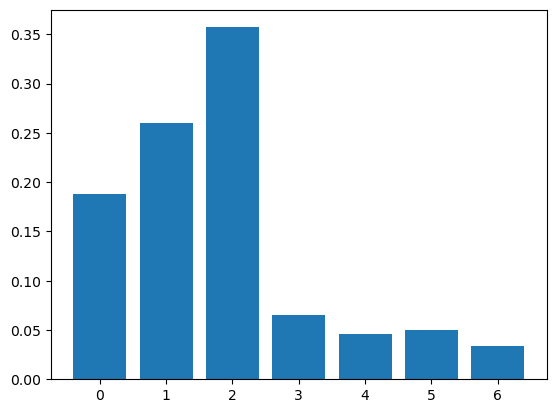

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

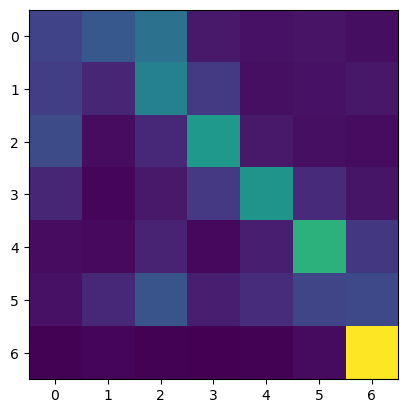

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

/tmp/wsuser/ipykernel_416/3262901620.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/wsuser/ipykernel_416/3262901620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


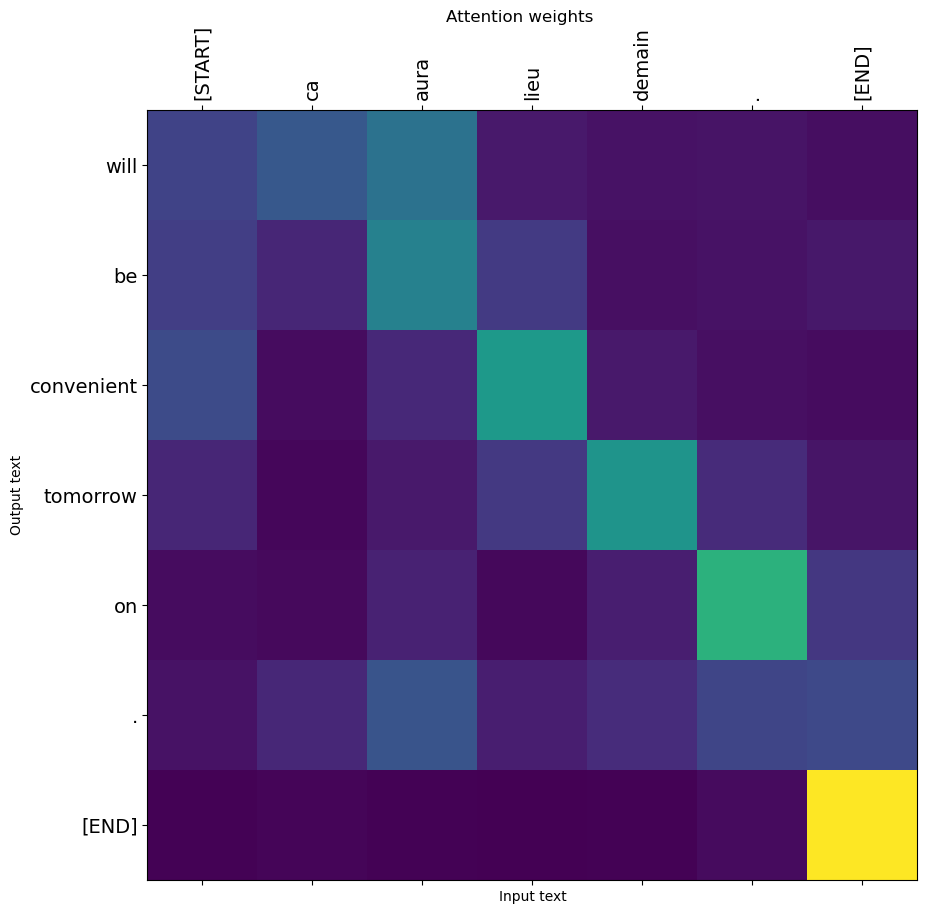

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [ ]:
%%time
three_input_text = tf.constant([
    # This is my life.
    "chante s'il te plait.",
    # Are they still home?
    'devrait-on marcher?',
    # Try to find out.'
    'soit content.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

please sing .
will you be able to walk ?
speak to me .

CPU times: user 192 ms, sys: 12.2 ms, total: 204 ms
Wall time: 66 ms


In [ ]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'please sing .', b'will you be able to walk ?', b'speak to me .'],
      dtype=object)>

/tmp/wsuser/ipykernel_416/3262901620.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/wsuser/ipykernel_416/3262901620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


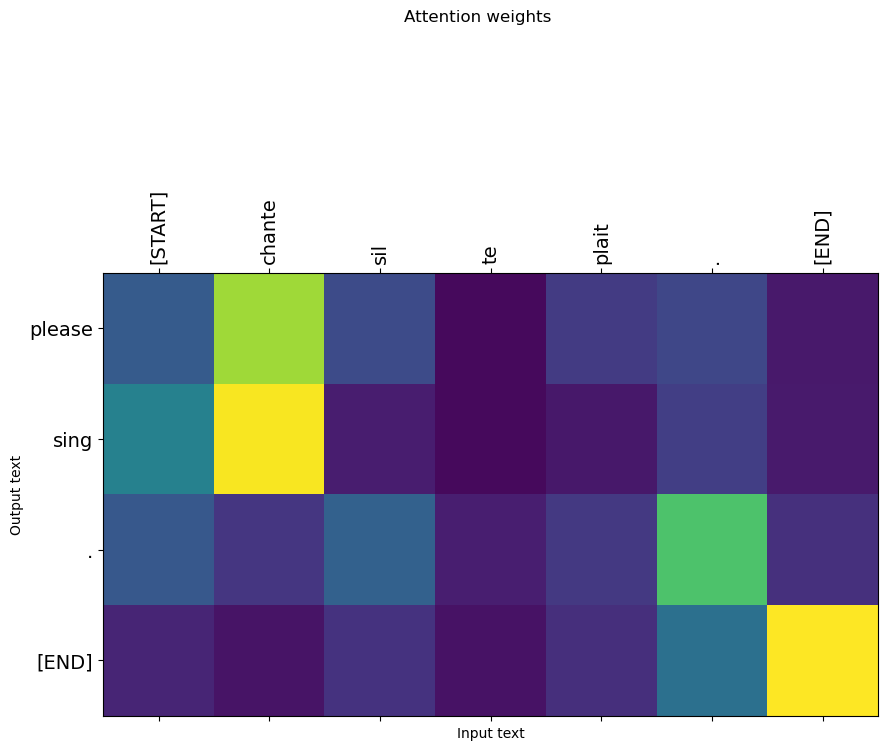

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/wsuser/ipykernel_416/3262901620.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/wsuser/ipykernel_416/3262901620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


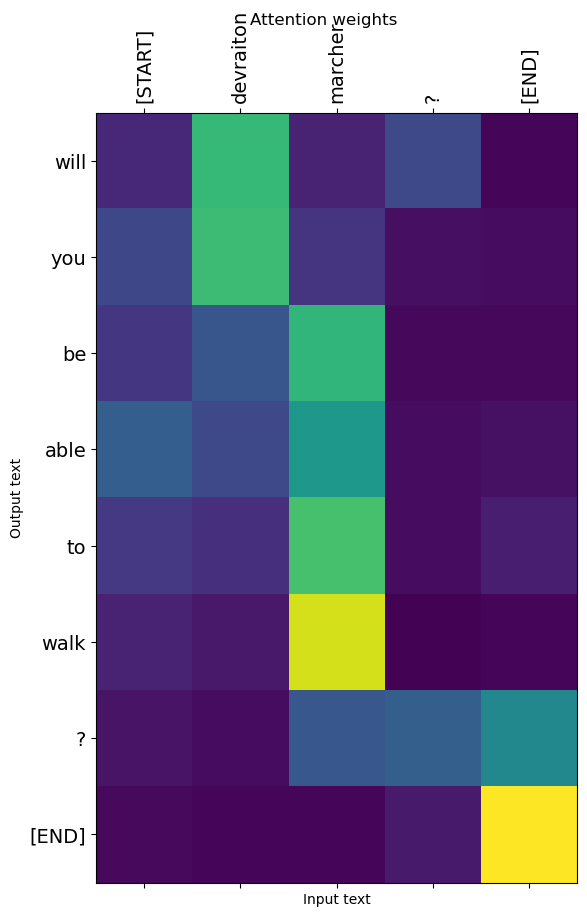

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/wsuser/ipykernel_416/3262901620.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/wsuser/ipykernel_416/3262901620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


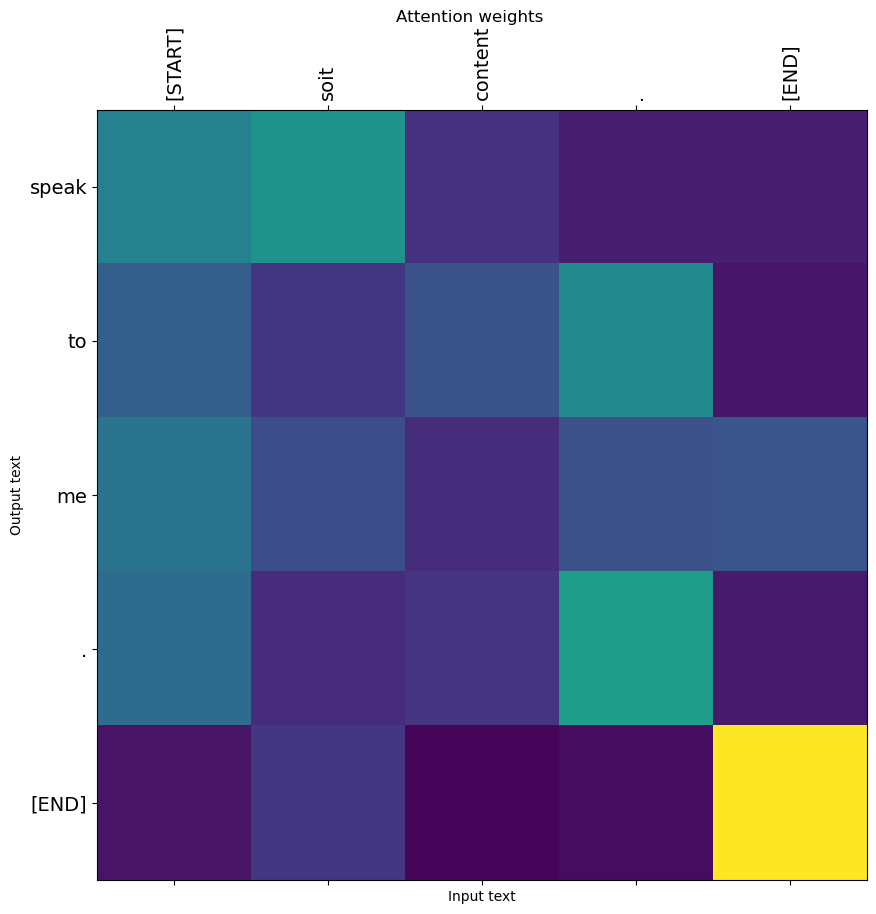

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 It may be impossible to get a completely error-free corpus due to the
nature of this kind of collaborative effort. However, if we encourage
members to contribute sentences in their own languages rather than
experiment in languages they are learning, we might be able to
minimize errors.


/tmp/wsuser/ipykernel_416/3262901620.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/wsuser/ipykernel_416/3262901620.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


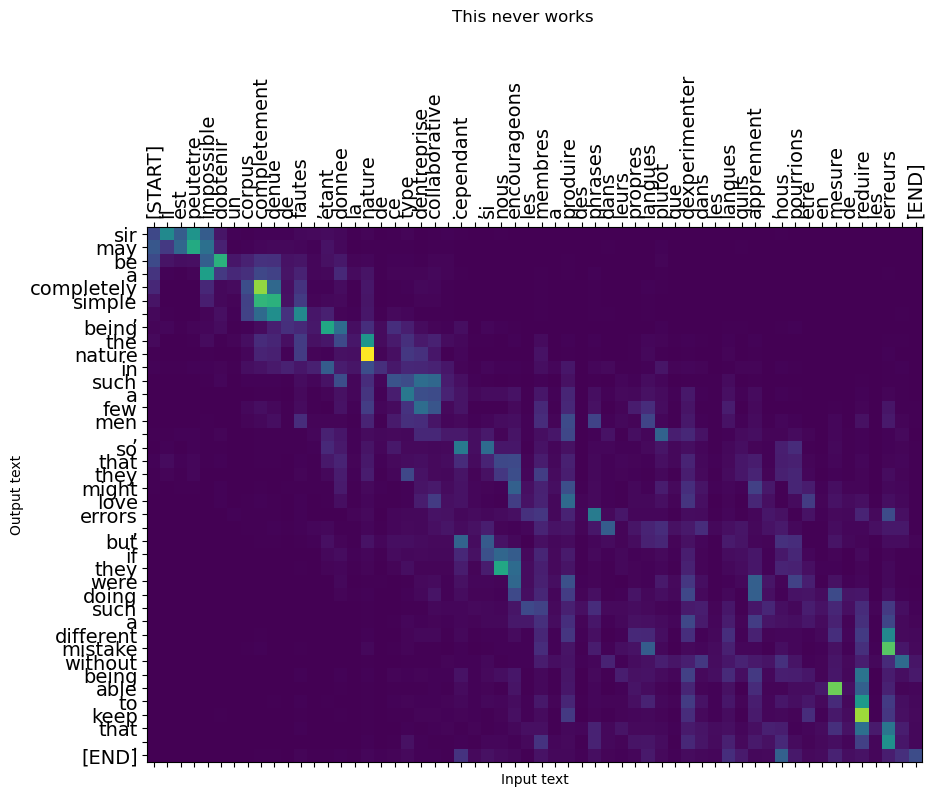

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

In [ ]:
# sauvegarde du model
"""
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})
"""


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


## Nous importons le model déja entrainé

In [ ]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
metadata_5 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-1-450d-9aef-59f60ec1aab9',
    'IBM_API_KEY_ID': '_K9kKnfQ26uY7SJkmoIEEOCyJYOB',
    'ENDPOINT': 'https://s3.private.eu.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'nlptranslationseq2seqwithattentio-donotdelete-pr-medpzvaa1j3gyb',
    'FILE': 'translator_Tarek_corpus_160K_folder.zip'
}


In [ ]:
from ibm_botocore.client import Config
import ibm_boto3
def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

In [ ]:
download_file_cos(metadata_5,'translator_Tarek_corpus_160K_folder.zip','translator_Tarek_corpus_160K_folder.zip')

File Downloaded


In [ ]:
from zipfile import ZipFile 
with ZipFile ('translator_Tarek_corpus_160K_folder.zip', 'r') as zipObj : 
    #Extraire tt les fichiers dans le directory : 
    zipObj.extractall()

In [ ]:
import os
os.listdir()

['variables',
 'assets',
 'saved_model.pb',
 '__MACOSX',
 'translator_Tarek_corpus_160K.zip',
 '.virtual_documents',
 'translator_Tarek_corpus_160K_folder.zip',
 'translator_Tarek_corpus_160K_folder']

In [ ]:
os.chdir("translator_Tarek_corpus_160K_folder")

In [ ]:
reloaded = tf.saved_model.load('translator')
three_input_text = tf.constant([
    # This is my life.
    "chante s'il te plait.",
    # Are they still home?
    'devrait-on marcher?',
    # Try to find out.'
    'soit content.',
])

result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

please sing .
do you use walking ?
is nothing glad .

CPU times: user 147 ms, sys: 17.2 ms, total: 164 ms
Wall time: 53.9 ms
